In [5]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.compose import ColumnTransformer 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
#import lightgbm as lgb

In [6]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense
import tensorflow as tf

# Data Preparation

## Acquire Data

In [47]:
# We only get the train data set
current_path = os.getcwd()+"\\"
file = os.path.sep.join(["..\\data\\train.csv"])
df = pd.read_csv(current_path + file)
df.columns = df.columns.str.strip()
X = np.asarray(df)[:,:-2]
y = np.asarray(df)[:,-1]

## Scaling the data

In [48]:
#Standarazing all of the signal variables. Use RobustScaler to avoid outilers effect when normalizing.
X_rscaled=X.copy()
rscaler = RobustScaler()
#X_rscaled[X_scaled.columns.values] = scaler.fit_transform(X_scaled[X_scaled.columns.values])
X_rscaled = rscaler.fit_transform(X_rscaled)

Using **Robust Scaling** to avoid outliers effect when scaling

More info in: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

# Model Training and testing

## Neural Network

In [50]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X_rscaled, y, test_size=0.1,random_state=0,shuffle=True)

In [52]:
#Shape of train data
print('Shape of training data:',X_train.shape)

Shape of training data: (191395, 15)


In [53]:
#Model: Fully connected neural network
input_data = Input(shape=(15,))
denselayer1 = Dense(units=100, activation = 'relu',input_shape = (14,))(input_data)
denselayer2 = Dense(units=90,activation = 'relu')(denselayer1)
denselayer3 = Dense(units=80,activation = 'relu')(denselayer2)
denselayer4 = Dense(units=70,activation = 'relu')(denselayer3)
denselayer5 = Dense(units=60,activation = 'relu')(denselayer4)
denselayer6 = Dense(units=50,activation = 'relu')(denselayer5)
denselayer7 = Dense(units=25,activation = 'relu')(denselayer6)
outputlayer = Dense(units=1, activation='sigmoid')(denselayer7)
model = Model(inputs=input_data, outputs=outputlayer,name="BosonNN")
model.summary()

Model: "BosonNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               1600      
_________________________________________________________________
dense_17 (Dense)             (None, 90)                9090      
_________________________________________________________________
dense_18 (Dense)             (None, 80)                7280      
_________________________________________________________________
dense_19 (Dense)             (None, 70)                5670      
_________________________________________________________________
dense_20 (Dense)             (None, 60)                4260      
_________________________________________________________________
dense_21 (Dense)             (None, 50)                3050

In [54]:
# Compile the model.
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['binary_accuracy'],
)

In [55]:
# Train the model.
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
callback = EarlyStopping(monitor='val_loss', mode='min',patience=20, verbose=1)

history=model.fit(
  X_train,
  y_train,
  validation_split=0.25,
  epochs=200,
  batch_size=32,
  callbacks=[callback]
    )

Epoch 1/200
4486/4486 [==============================] - 6s 1ms/step - loss: 0.4648 - binary_accuracy: 0.7717 - val_loss: 0.4450 - val_binary_accuracy: 0.7835
Epoch 2/200
4486/4486 [==============================] - 6s 1ms/step - loss: 0.4370 - binary_accuracy: 0.7894 - val_loss: 0.4287 - val_binary_accuracy: 0.7934
Epoch 3/200
4486/4486 [==============================] - 6s 1ms/step - loss: 0.4227 - binary_accuracy: 0.7983 - val_loss: 0.4183 - val_binary_accuracy: 0.8003
Epoch 4/200
4486/4486 [==============================] - 6s 1ms/step - loss: 0.4090 - binary_accuracy: 0.8059 - val_loss: 0.4032 - val_binary_accuracy: 0.8091
Epoch 5/200
4486/4486 [==============================] - 6s 1ms/step - loss: 0.3996 - binary_accuracy: 0.8132 - val_loss: 0.3978 - val_binary_accuracy: 0.8146
Epoch 6/200
4486/4486 [==============================] - 6s 1ms/step - loss: 0.3933 - binary_accuracy: 0.8150 - val_loss: 0.3988 - val_binary_accuracy: 0.8126
Epoch 7/200
4486/4486 [=======================

In [56]:
NNpredictions_train = model.predict(X_train)
NNpredictions_test = model.predict(X_test)

In [57]:
print('Train',roc_auc_score(y_train,predictions_train))
print('Test',roc_auc_score(y_test,predictions_test))

Train 0.9122477804137207
Test 0.8945380797885667


In [67]:
import pickle
current_path = os.getcwd()+"\\"
pkl_filename = os.path.sep.join(["pickle_model_gbdt.pkl"])
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [69]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=0,shuffle=True)

In [70]:
print(roc_auc_score(y_train, pickle_model.predict(X_train,num_iteration=pickle_model.best_iteration)))
print(roc_auc_score(y_test, pickle_model.predict(X_test,num_iteration=pickle_model.best_iteration)))

0.909439490334897
0.8731263705334331


In [71]:
LGpredictions=pickle_model.predict(X_test,num_iteration=pickle_model.best_iteration)

# EDA Starts here

In [93]:
d={'Y':y_test,'NNY':NNpredictions_test[:,0],'LBY':LGpredictions}
df = pd.DataFrame(data=d)

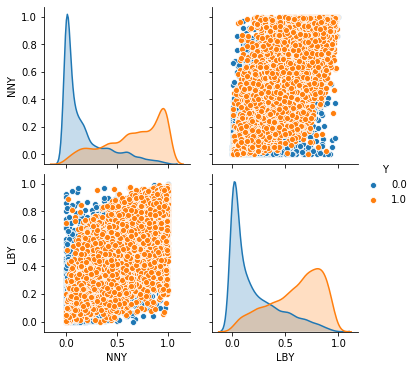

In [96]:
sns.pairplot(data=df,hue="Y")